In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

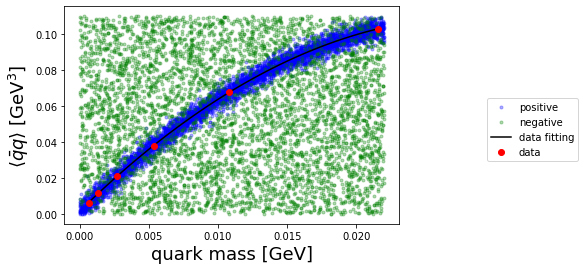

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=5000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [6]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
[ 3.0887604   6.9241796   0.91360366  8.806518    4.4693055   7.900878
  3.8892565   5.6641364   5.0119824   1.021274    8.374434   -0.3021157
  4.785579   -2.6800497   3.6757166 ]


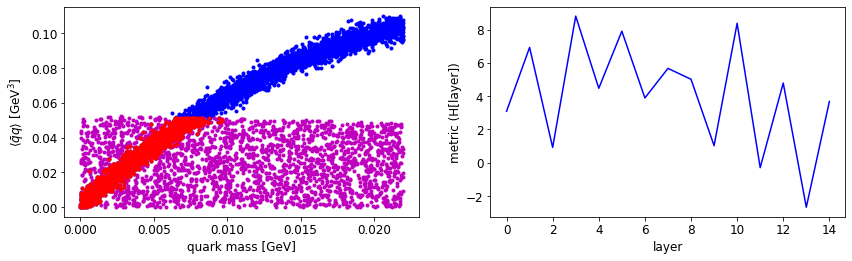

In [28]:
d = 4
m2 = -3 # mass^2
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
Test = MetricNet(Number_of_layers=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta,d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters(), lr=0.01) 
Test.train()

print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [17]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

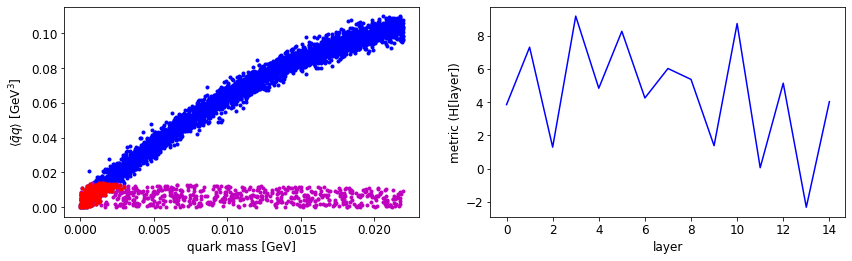

training epoch: 0,   loss: 0.3048209547996521
lambda: 0.574015736579895,   AdS radius: 1.1073518991470337[1/GeV]
[ 3.8456953   7.303686    1.2873865   9.175276    4.833799    8.262064
  4.2476563   6.0204177   5.366471    1.3740814   8.72633     0.04832279
  5.13548    -2.3314197   4.024166  ]


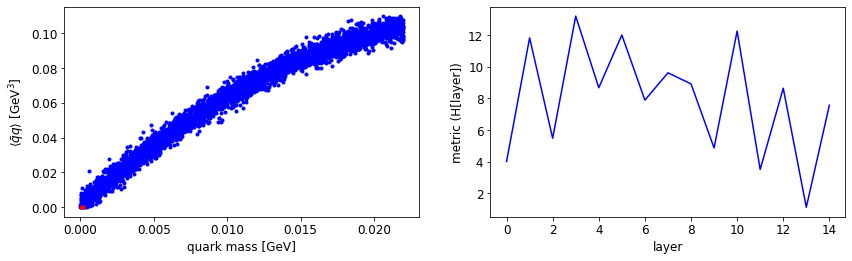

training epoch: 100,   loss: 0.25212323665618896
lambda: 2.0621695518493652,   AdS radius: 1.8456964492797852[1/GeV]
[ 4.001073  11.817111   5.4732    13.19228    8.666209  12.000153
  7.8819537  9.608892   8.910452   4.861208  12.245933   3.5009546
  8.632916   1.1119684  7.560066 ]


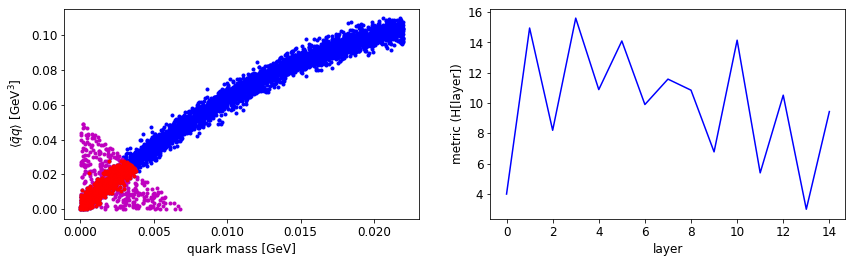

training epoch: 200,   loss: 0.21550588309764862
lambda: 4.685728073120117,   AdS radius: 0.19375935196876526[1/GeV]
[ 3.9951587 14.954611   8.205088  15.608768  10.890901  14.099457
  9.904999  11.582288  10.85178    6.7802916 14.152104   5.3948817
 10.522007   2.9931746  9.440939 ]


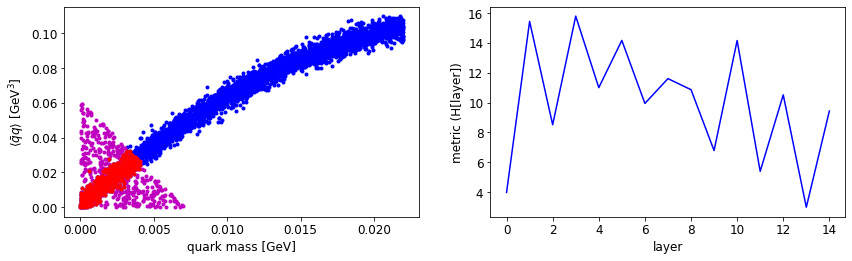

training epoch: 300,   loss: 0.21574804186820984
lambda: 6.0004754066467285,   AdS radius: 0.1789926439523697[1/GeV]
[ 3.986248  15.437456   8.519362  15.789705  11.002058  14.163328
  9.945749  11.605835  10.866097   6.7914248 14.154279   5.4002256
 10.521339   2.996913   9.436902 ]


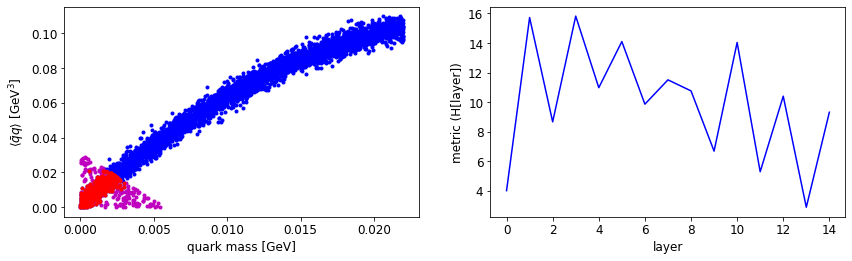

training epoch: 400,   loss: 0.21752196550369263
lambda: 7.0719523429870605,   AdS radius: 0.22639480233192444[1/GeV]
[ 4.0012956 15.720491   8.659739  15.817799  10.972202  14.093922
  9.857274  11.50292   10.755469   6.678416  14.03327    5.282479
 10.398086   2.8778994  9.310687 ]


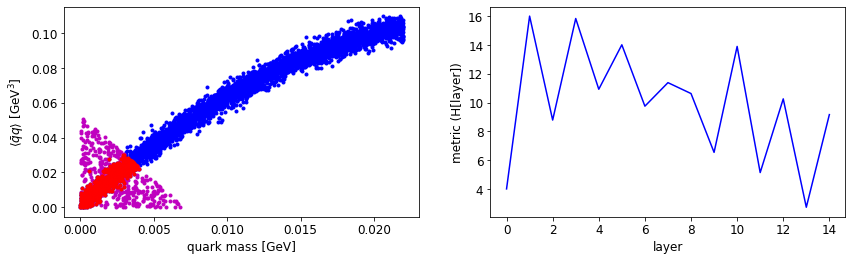

training epoch: 500,   loss: 0.21655046939849854
lambda: 8.30713939666748,   AdS radius: 0.1918487250804901[1/GeV]
[ 4.014353  15.998278   8.789367  15.832215  10.927234  14.00867
  9.752622  11.383539  10.628206   6.548723  13.895408   5.147857
 10.257872   2.7419443  9.167411 ]


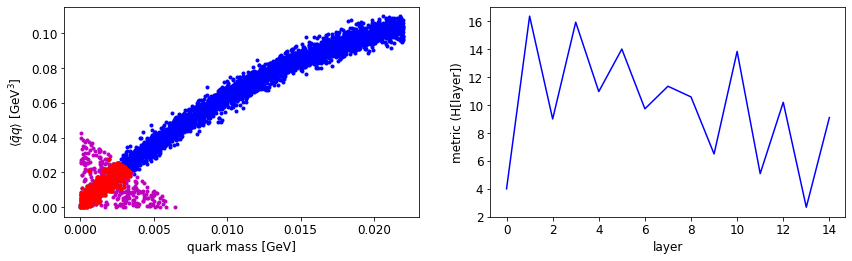

training epoch: 600,   loss: 0.2159249484539032
lambda: 9.96316909790039,   AdS radius: 0.20541267096996307[1/GeV]
[ 3.9988885 16.358189   8.997455  15.923338  10.958275  13.99882
  9.723166  11.3390665 10.575809   6.493811  13.832122   5.087894
 10.19214    2.6805658  9.098392 ]


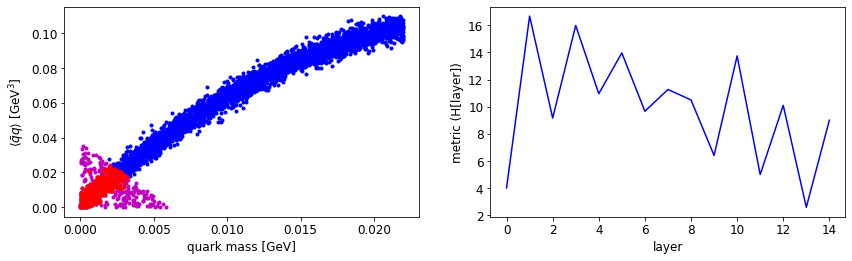

training epoch: 700,   loss: 0.21985244750976562
lambda: 11.142119407653809,   AdS radius: 0.21860001981258392[1/GeV]
[ 4.016127  16.67191    9.164918  15.979281  10.957303  13.959042
  9.664929  11.2666445 10.495775   6.4115577 13.741754   5.0008764
 10.09945    2.5921948  9.002566 ]


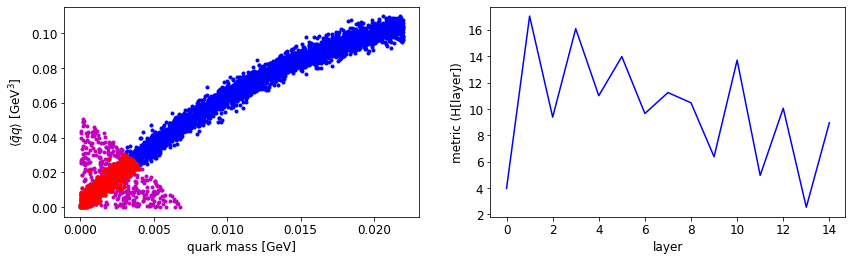

training epoch: 800,   loss: 0.2151845544576645
lambda: 12.3619384765625,   AdS radius: 0.18951092660427094[1/GeV]
[ 3.977945  17.031551   9.376301  16.078522  10.999732  13.962932
  9.650356  11.237855  10.459523   6.373048  13.695073   4.9575987
 10.050427   2.5475752  8.950273 ]


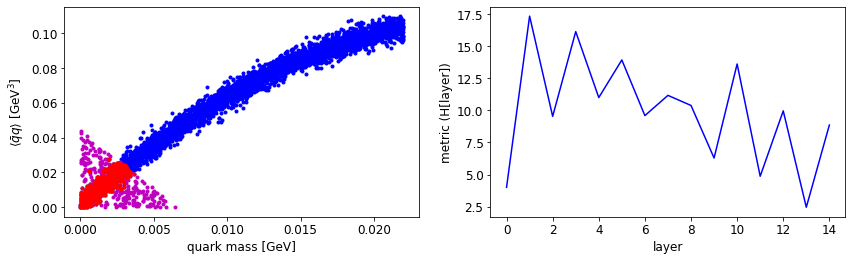

training epoch: 900,   loss: 0.21587687730789185
lambda: 13.645841598510742,   AdS radius: 0.20521552860736847[1/GeV]
[ 4.0055604 17.327389   9.528681  16.123503  10.990516  13.916865
  9.586908  11.160885  10.375375   6.2869644 13.60096    4.866945
  9.954084   2.4557197  8.8507595]


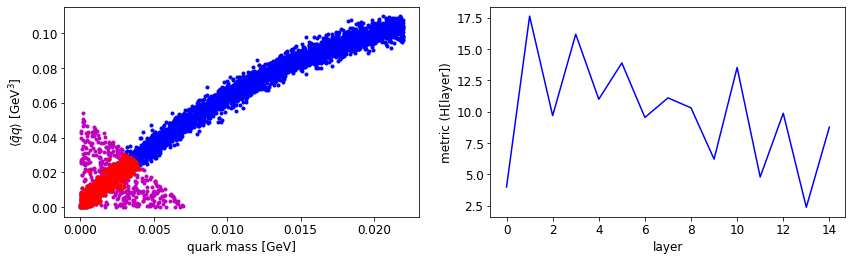

training epoch: 1000,   loss: 0.21445320546627045
lambda: 14.908798217773438,   AdS radius: 0.19143842160701752[1/GeV]
[ 3.9896724 17.611975   9.676129  16.169016  10.9849    13.876413
  9.530164  11.091351  10.299113   6.208966  13.515181   4.7846446
  9.866245   2.3722508  8.759767 ]


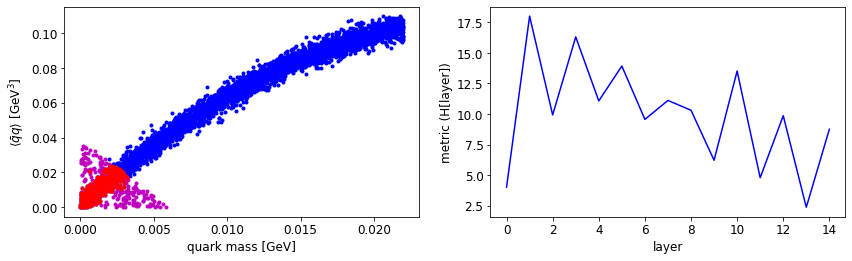

training epoch: 1100,   loss: 0.21735401451587677
lambda: 16.277660369873047,   AdS radius: 0.2137593775987625[1/GeV]
[ 4.0204763 18.011803   9.928503  16.312828  11.074049  13.928599
  9.564844  11.112262  10.31275    6.220575  13.51856    4.7914934
  9.867261   2.3776643  8.757371 ]


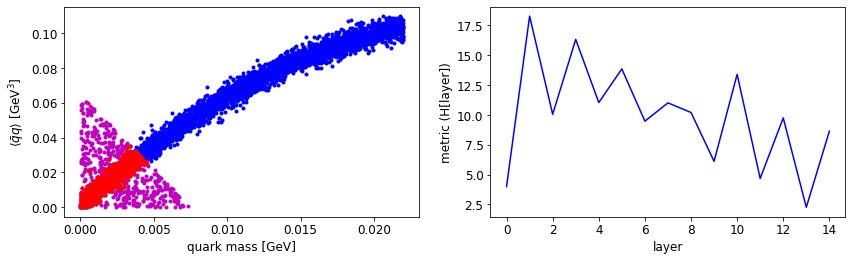

training epoch: 1200,   loss: 0.21573112905025482
lambda: 17.538930892944336,   AdS radius: 0.18130303919315338[1/GeV]
[ 3.9904377 18.285303  10.05562   16.332823  11.04083   13.859099
  9.478425  11.012435  10.205911   6.1118875 13.401546   4.6782327
  9.748013   2.2630856  8.634641 ]


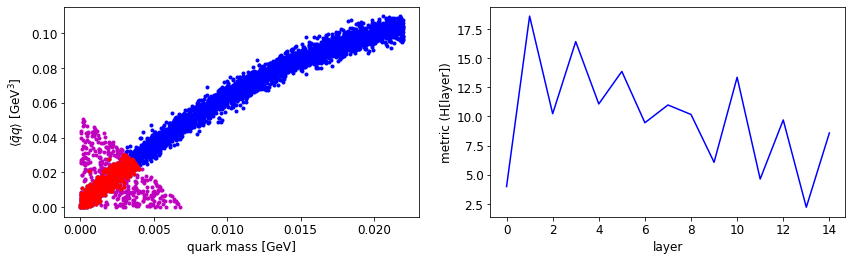

training epoch: 1300,   loss: 0.2168038785457611
lambda: 18.81852149963379,   AdS radius: 0.19104671478271484[1/GeV]
[ 3.992215  18.599512  10.2353525 16.414818  11.074417  13.859748
  9.463738  10.985572  10.17262    6.077042  13.358926   4.639244
  9.703338   2.2228677  8.586703 ]


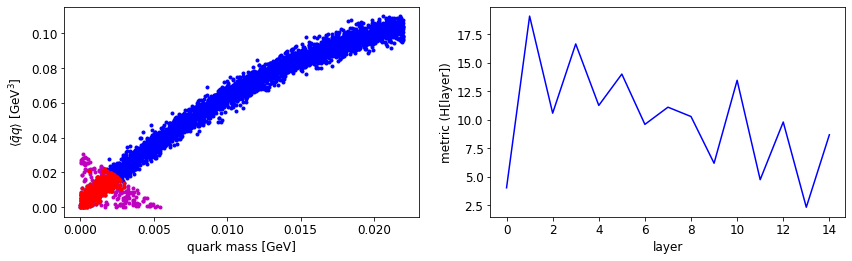

training epoch: 1400,   loss: 0.21753841638565063
lambda: 20.41716194152832,   AdS radius: 0.22272171080112457[1/GeV]
[ 4.0185943 19.077341  10.564261  16.63679   11.243504  13.992952
  9.580319  11.088868  10.268888   6.1715655 13.445065   4.729147
  9.787241   2.3113902  8.666996 ]


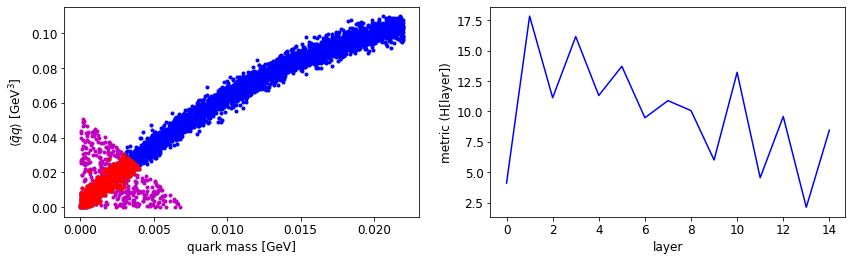

training epoch: 1500,   loss: 0.24910219013690948
lambda: 21.52423095703125,   AdS radius: 0.19523786008358002[1/GeV]
[ 4.1046567 17.843744  11.126103  16.16153   11.313694  13.714946
  9.480833  10.887286  10.069434   6.008143  13.216338   4.545455
  9.581822   2.117475   8.462318 ]


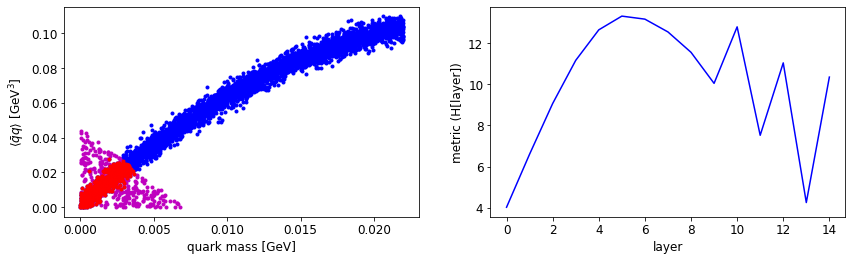

training epoch: 1600,   loss: 0.21847760677337646
lambda: 24.727153778076172,   AdS radius: 0.19671161472797394[1/GeV]
[ 4.025891   6.6069293  9.067226  11.164761  12.647625  13.314863
 13.16781   12.545706  11.555405  10.046792  12.793204   7.5231323
 11.0415535  4.2542067 10.35162  ]


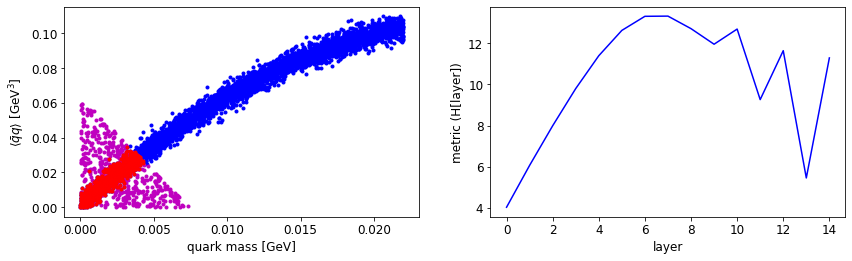

training epoch: 1700,   loss: 0.2172446846961975
lambda: 26.690988540649414,   AdS radius: 0.1686273217201233[1/GeV]
[ 4.0192266  6.0582967  7.9872737  9.798777  11.397831  12.631479
 13.317969  13.32755   12.717266  11.958839  12.69655    9.261558
 11.644026   5.4458146 11.2915125]


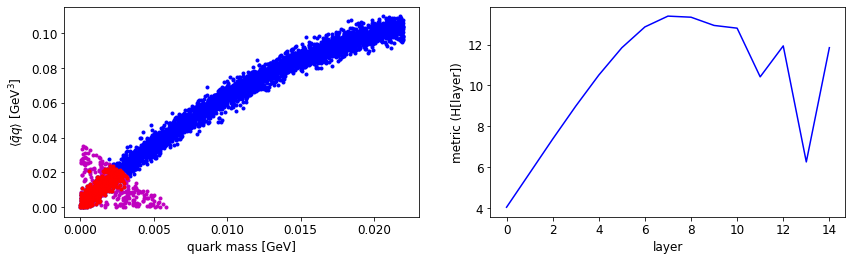

training epoch: 1800,   loss: 0.21741178631782532
lambda: 28.454160690307617,   AdS radius: 0.20054709911346436[1/GeV]
[ 4.0327997  5.6997976  7.3687053  8.981391  10.501662  11.841825
 12.861041  13.389918  13.33682   12.933482  12.799762  10.41747
 11.931675   6.251718  11.844369 ]


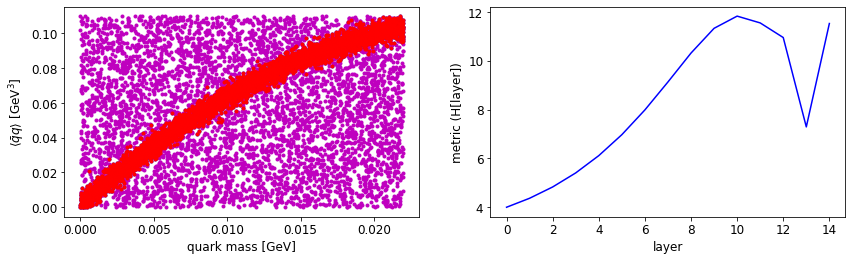

training epoch: 1900,   loss: 0.2527365982532501
lambda: 28.824838638305664,   AdS radius: -0.03529241681098938[1/GeV]
[ 4.0036826  4.3718104  4.8342466  5.4093165  6.11697    6.9748135
  7.988756   9.133565  10.317191  11.329925  11.829786  11.551404
 10.952899   7.2935123 11.527196 ]


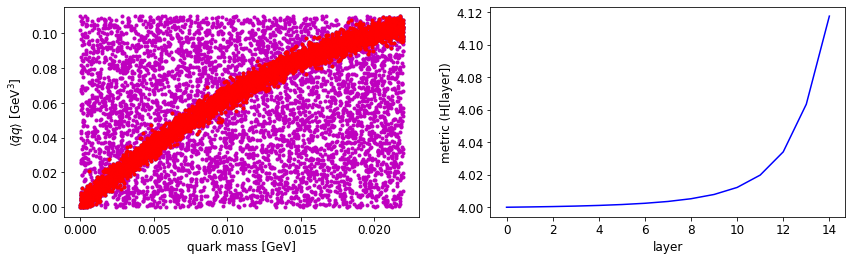

training epoch: 2000,   loss: 0.25238391757011414
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[3.9999902 4.000179  4.000407  4.000707  4.001109  4.001658  4.00243
 4.003547  4.0052247 4.0078506 4.012179  4.0197787 4.0340805 4.0633974
 4.1176014]


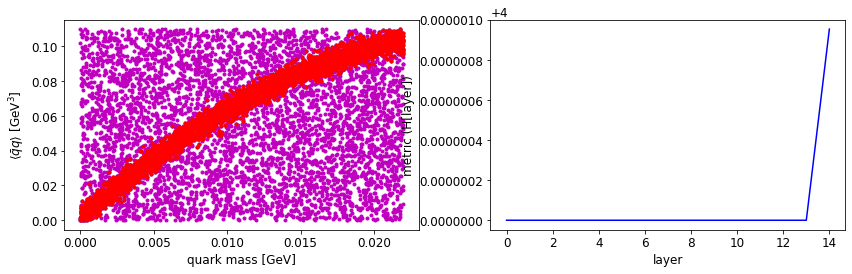

training epoch: 2100,   loss: 0.2520979344844818
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.       4.       4.       4.       4.       4.       4.       4.
 4.       4.       4.       4.       4.       4.       4.000001]


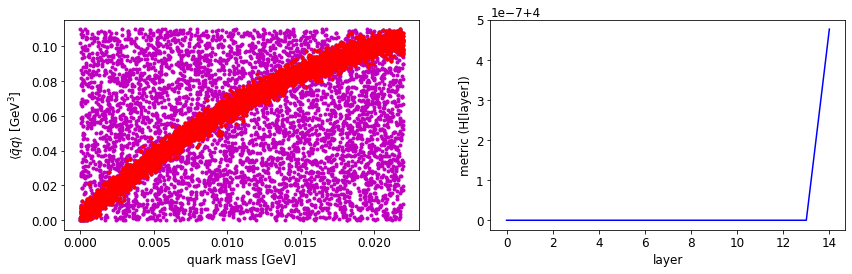

training epoch: 2200,   loss: 0.25224190950393677
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.        4.        4.        4.        4.        4.        4.
 4.        4.        4.        4.        4.        4.        4.
 4.0000005]


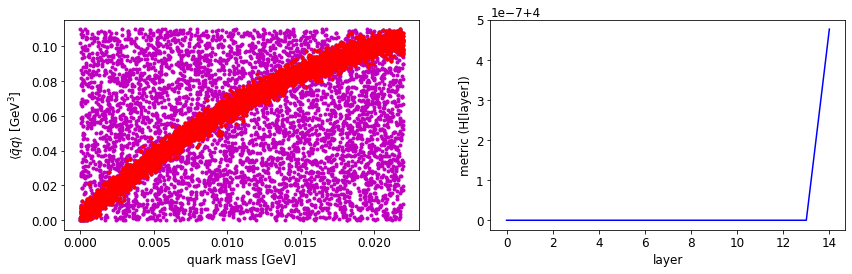

training epoch: 2300,   loss: 0.2529239356517792
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.        4.        4.        4.        4.        4.        4.
 4.        4.        4.        4.        4.        4.        4.
 4.0000005]


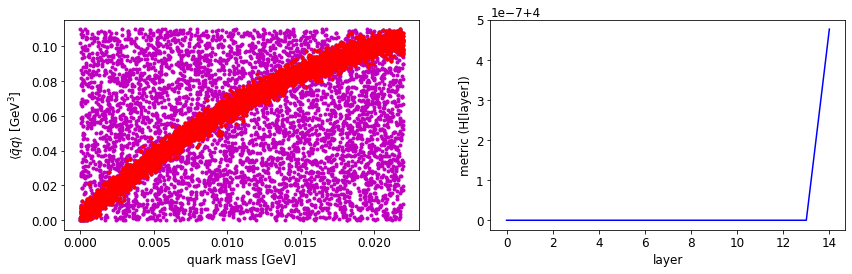

training epoch: 2400,   loss: 0.252815842628479
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.        4.        4.        4.        4.        4.        4.
 4.        4.        4.        4.        4.        4.        4.
 4.0000005]


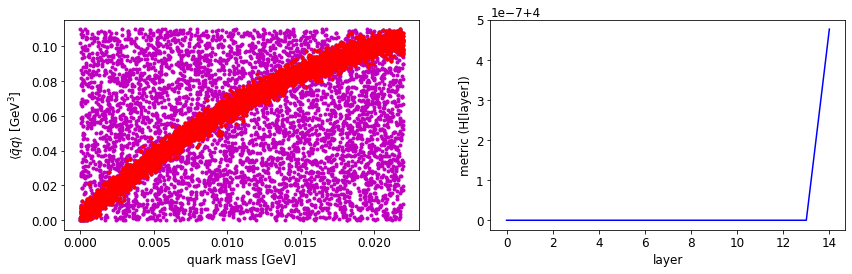

training epoch: 2500,   loss: 0.2528518736362457
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.        4.        4.        4.        4.        4.        4.
 4.        4.        4.        4.        4.        4.        4.
 4.0000005]


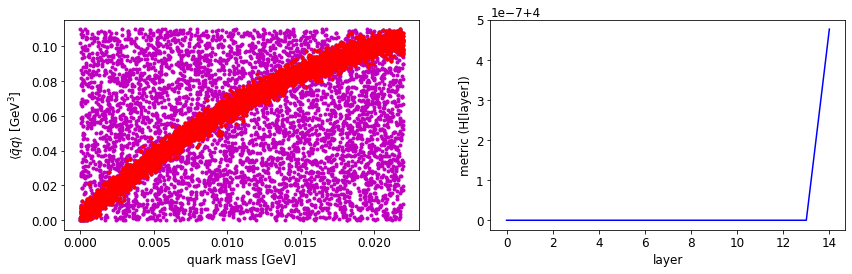

training epoch: 2600,   loss: 0.2528378963470459
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.        4.        4.        4.        4.        4.        4.
 4.        4.        4.        4.        4.        4.        4.
 4.0000005]


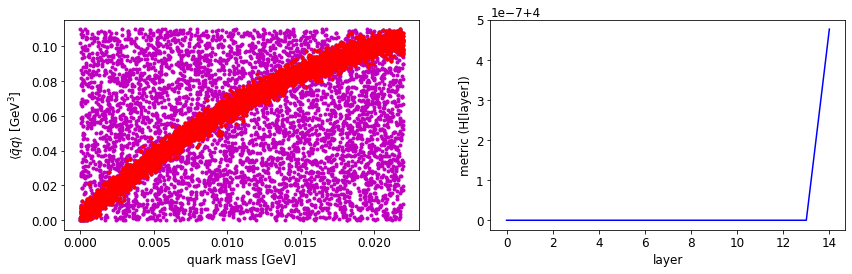

training epoch: 2700,   loss: 0.25283390283584595
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.        4.        4.        4.        4.        4.        4.
 4.        4.        4.        4.        4.        4.        4.
 4.0000005]


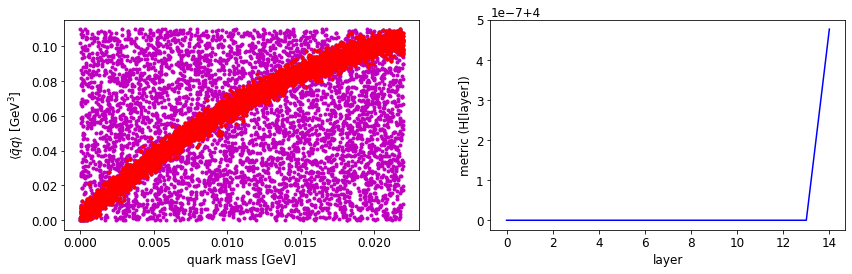

training epoch: 2800,   loss: 0.25212597846984863
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.        4.        4.        4.        4.        4.        4.
 4.        4.        4.        4.        4.        4.        4.
 4.0000005]


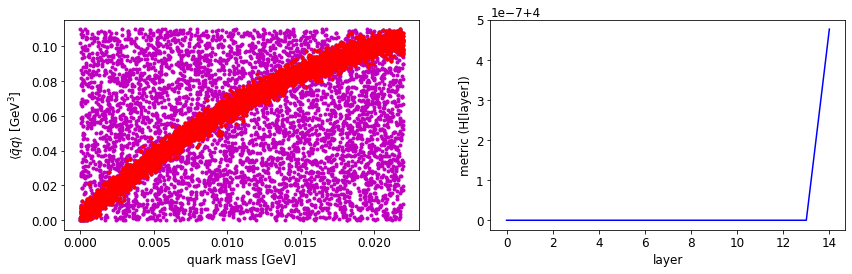

training epoch: 2900,   loss: 0.25242188572883606
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.        4.        4.        4.        4.        4.        4.
 4.        4.        4.        4.        4.        4.        4.
 4.0000005]


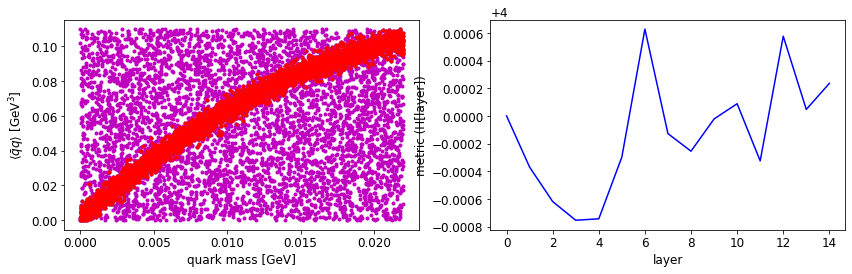

training epoch: 3000,   loss: 0.2528385818004608
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4.0000014 3.9996305 3.999381  3.9992456 3.999256  3.999703  4.00063
 3.999873  3.9997458 3.9999793 4.0000896 3.9996755 4.0005784 4.000048
 4.000237 ]


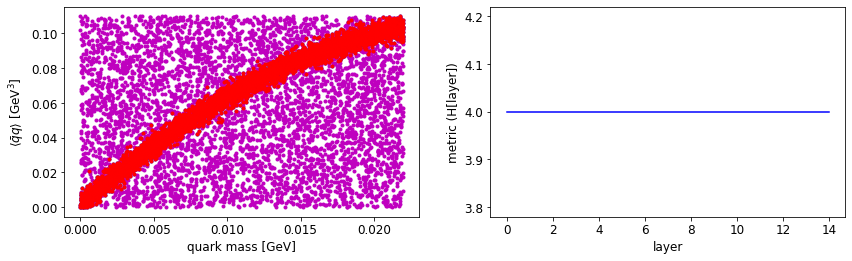

training epoch: 3100,   loss: 0.25244584679603577
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


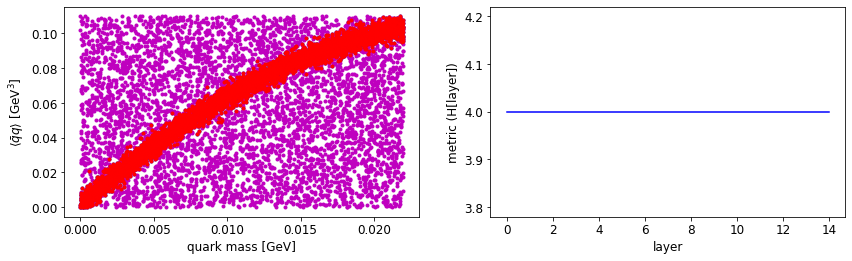

training epoch: 3200,   loss: 0.25288596749305725
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


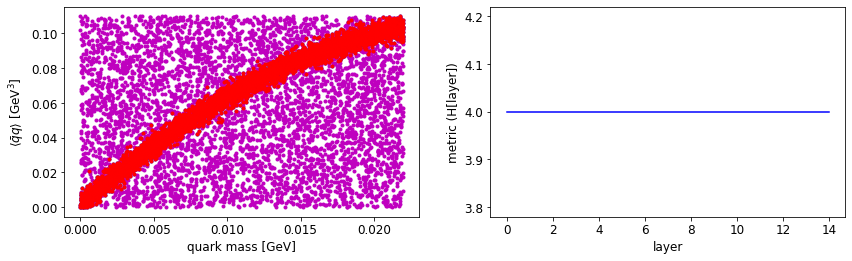

training epoch: 3300,   loss: 0.25219789147377014
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


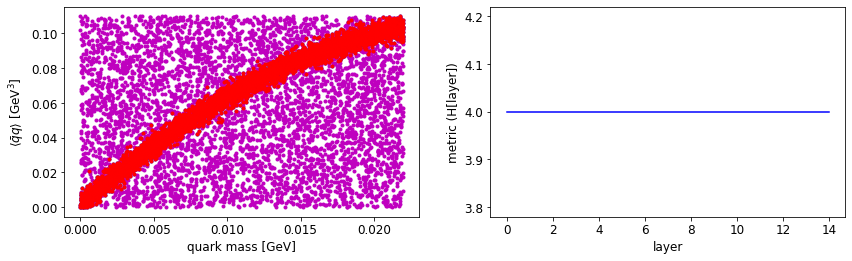

training epoch: 3400,   loss: 0.25204789638519287
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


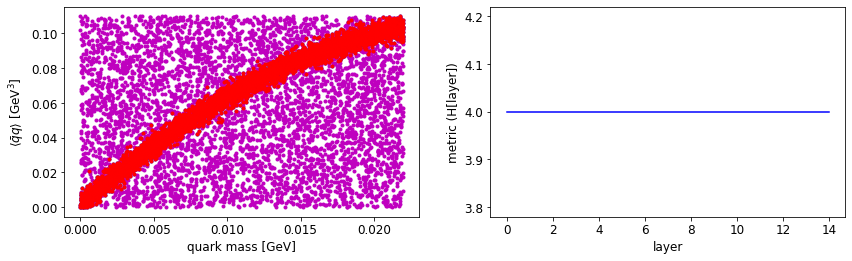

training epoch: 3500,   loss: 0.2523539066314697
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


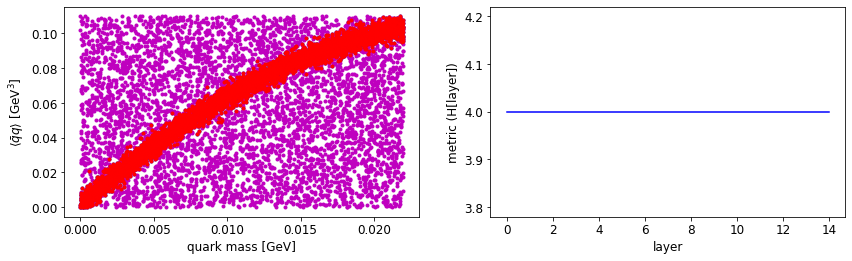

training epoch: 3600,   loss: 0.25207793712615967
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


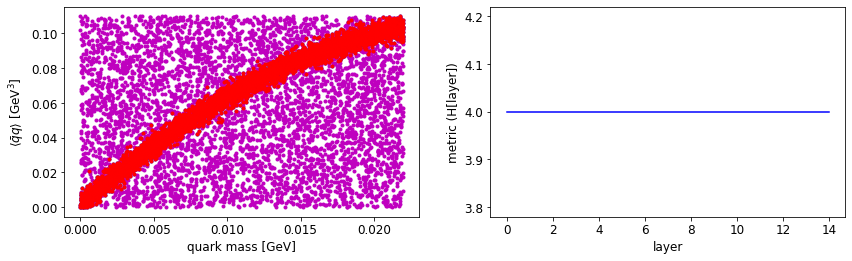

training epoch: 3700,   loss: 0.2527019679546356
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


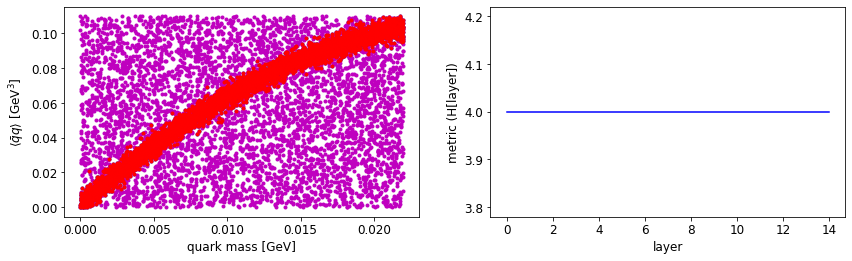

training epoch: 3800,   loss: 0.2522919178009033
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


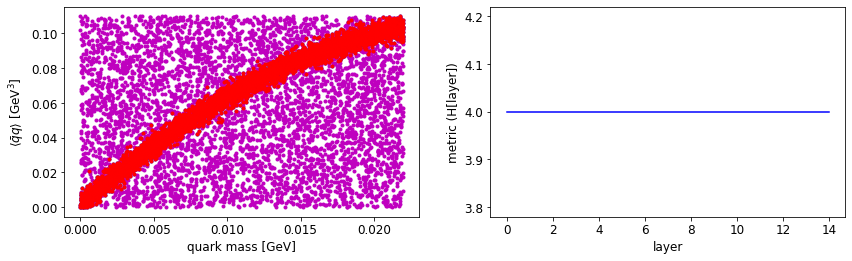

training epoch: 3900,   loss: 0.2522158920764923
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


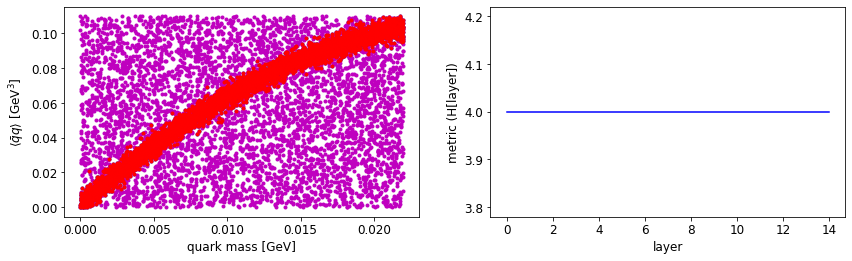

training epoch: 4000,   loss: 0.25178787112236023
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


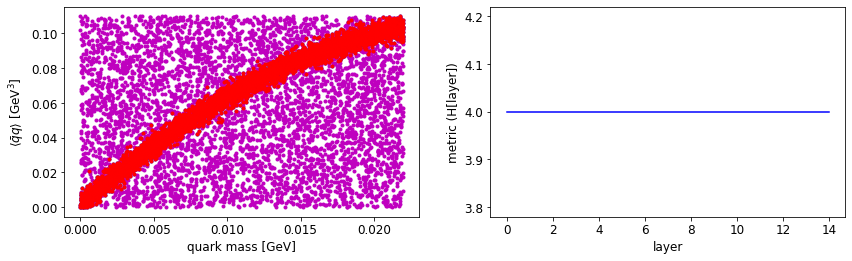

training epoch: 4100,   loss: 0.2528059184551239
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


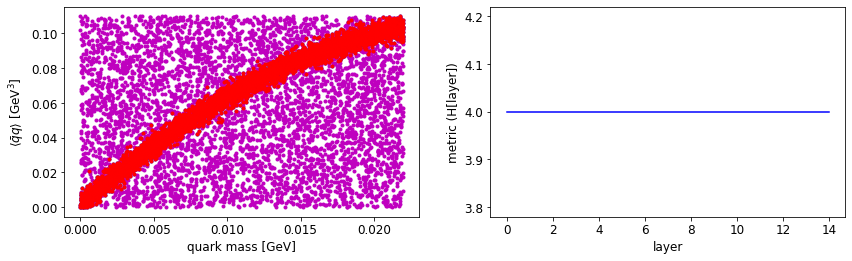

training epoch: 4200,   loss: 0.2528158724308014
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


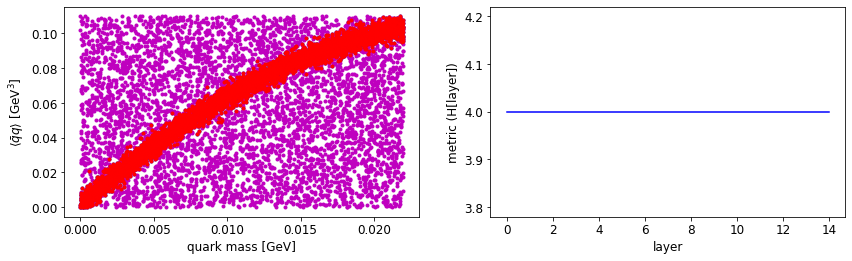

training epoch: 4300,   loss: 0.25228196382522583
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


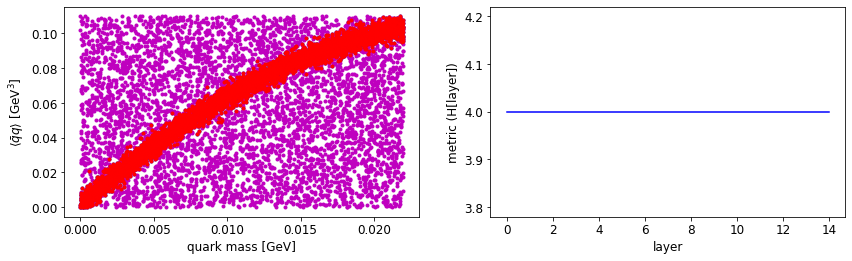

training epoch: 4400,   loss: 0.25208786129951477
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


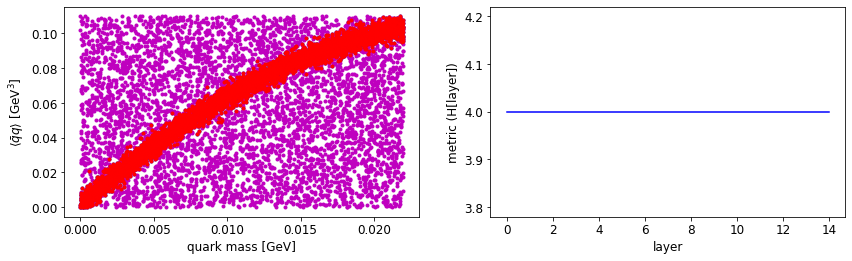

training epoch: 4500,   loss: 0.25197190046310425
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


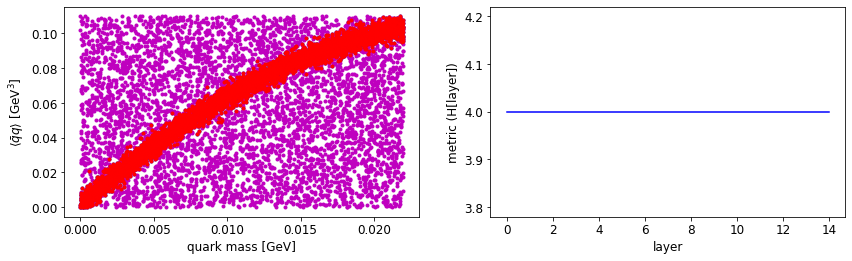

training epoch: 4600,   loss: 0.2531659007072449
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


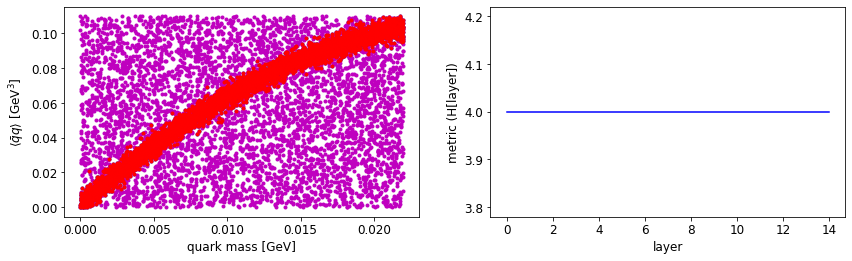

training epoch: 4700,   loss: 0.25232985615730286
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


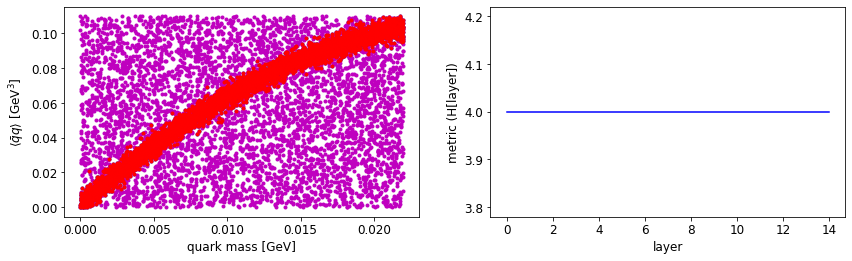

training epoch: 4800,   loss: 0.2528678774833679
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


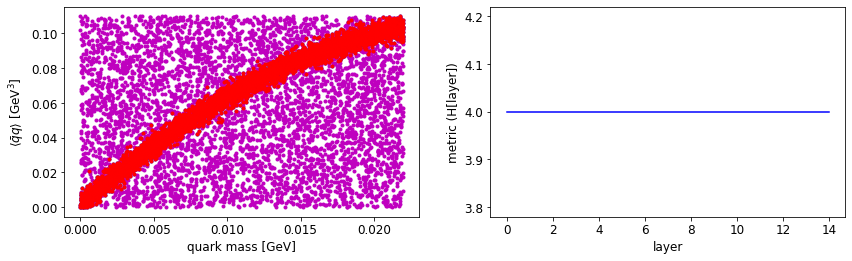

training epoch: 4900,   loss: 0.25232183933258057
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


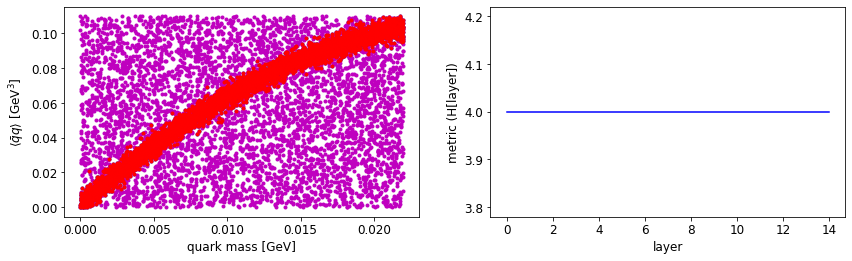

training epoch: 5000,   loss: 0.25244587659835815
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


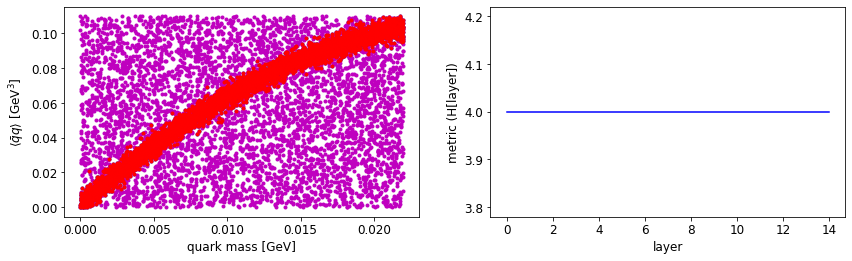

training epoch: 5100,   loss: 0.25227394700050354
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


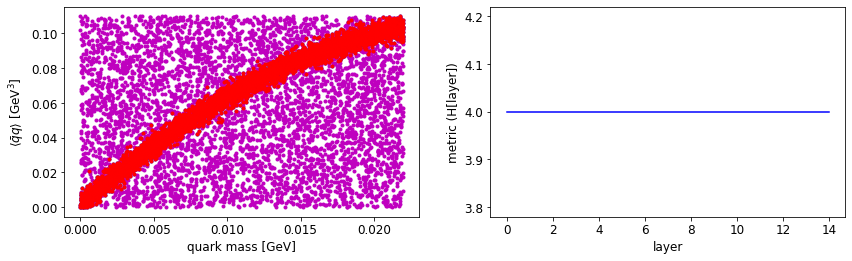

training epoch: 5200,   loss: 0.25285783410072327
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


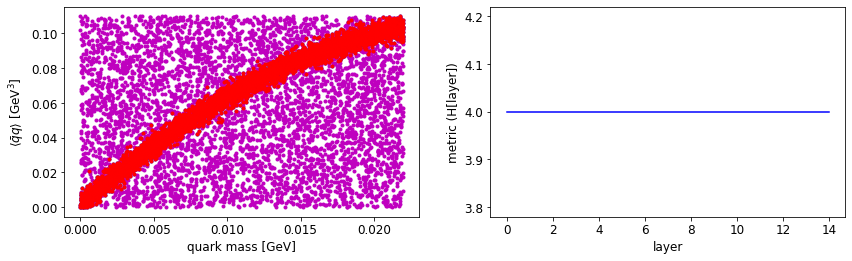

training epoch: 5300,   loss: 0.25244593620300293
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


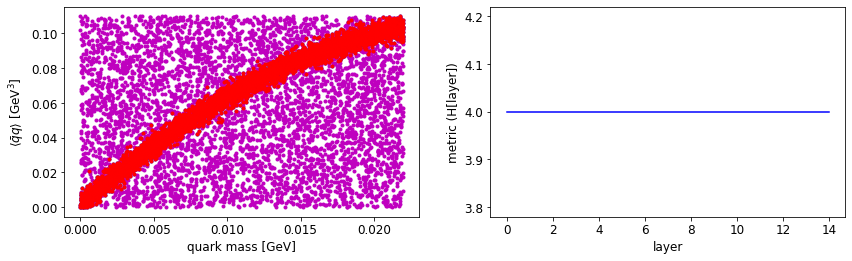

training epoch: 5400,   loss: 0.25227195024490356
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


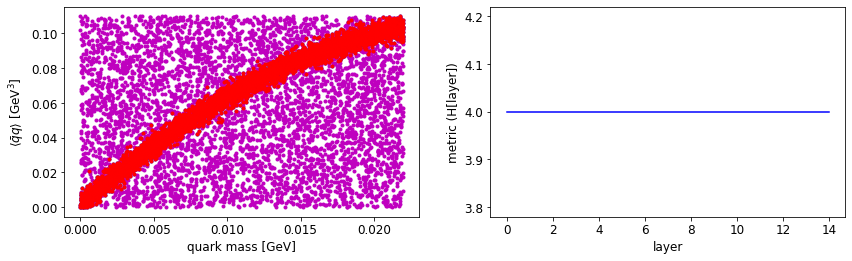

training epoch: 5500,   loss: 0.2524718940258026
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


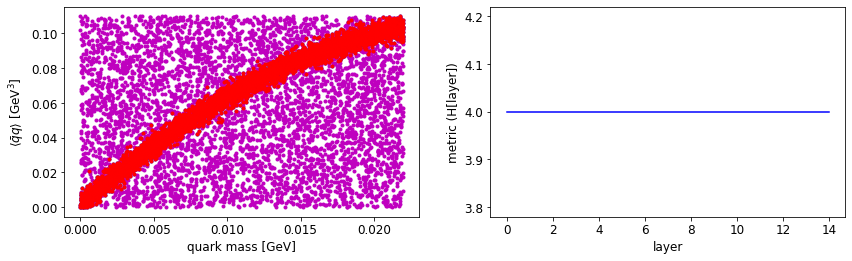

training epoch: 5600,   loss: 0.25249388813972473
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


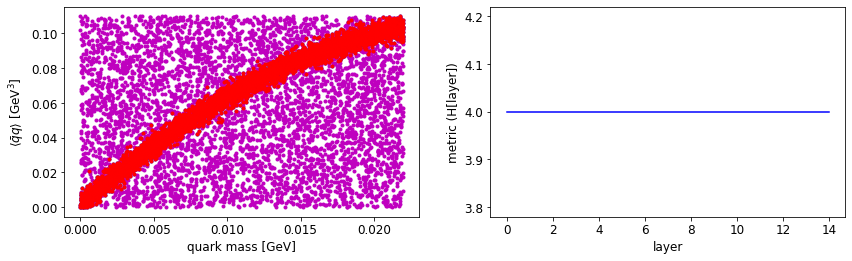

training epoch: 5700,   loss: 0.25266993045806885
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


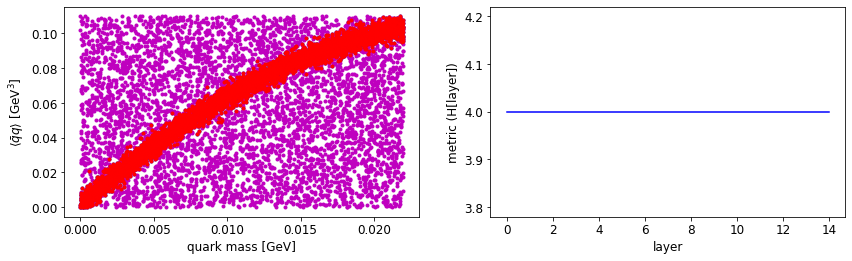

training epoch: 5800,   loss: 0.2523499131202698
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


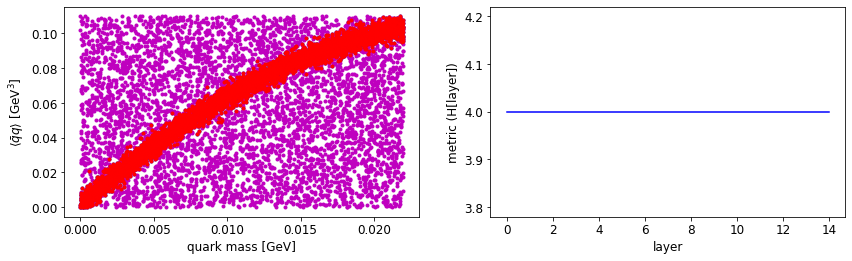

training epoch: 5900,   loss: 0.2526618242263794
lambda: 28.824838638305664,   AdS radius: -0.035290900617837906[1/GeV]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


In [29]:
total_epoch=6000
show_epoch_each=100

for epoch in range(total_epoch):
    if epoch==0:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==1500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==3000:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==4500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
print(c_reg1)

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)